# Project Summary

Ricardo B. Garcia (rbgarcia@gmail.com) 

This is a Data Science project aimed at deriving insights from data analysis to solve business problems. This project was inspired by the DS course of the Comunidade DS https://www.comunidadedatascience.com/. 

<b>Business problem</b> <br>
The NY Real Estate Company is a fictious company located in New York City. The company is focused on buying apartments for renting the apartment or private rooms in booking sites like airbnb.

The Company currently have 200 properties in Manhattan and the strategic plan is to increase the portfolio up to 400 properties, including properties outside but near Manhattan.

The business problem is finding properties with high potential profitability in in Manhattan and the surrounding neighbourhoods. To estimate the profitability of a property, the following formula is used by the business team:

$$ profitability = \frac{price * (minimum\_nights + 1) * number\_of\_reviews}{\sqrt{availability\_365}} $$

The Data Scientist was requested to:
- Analyze the airbnb dataset in search of the best properties for buying in the target neighbourhoods. 
- Use exploratory data analysis for understanding the location distribution, the price and popularity (rate of reviews) patterns in different boroughs and neighbourhoods of NYC.
- Plot maps for visualizing the location of properties in NYC boroughs and neighbourhoods, as well as for visualizing the median prices and number of reviews per neighbourhood.
- Analyze and compare price patterns in different regions of Manhattan (Lower, Mid, Central Park, Upper)
- Analyze prices around the Central Park

<b> Project's assumptions </b>
- The NY Company is focused on properties from US\\$ 20.00 to US\\$ 500.00 per night, of the types 'entire appartment' and 'private room'.
- The `AB_NYC_2019.csv` is the portfolio of properties listed in the market

**The dataset:** https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data

|    Attribute    |                         Meaning                         |
| :-------------: | :----------------------------------------------------------: |
|       id        |      Listing identification        |
|      name       |                    Name of the listing                     |
|      host_id      |    Host identification     |
|    host_name     |                     Name of the host                       |
|    neighbourhood_group    | Borough of NYC  |
|   neighbourhood   | Neighbourhood of NYC |
|    latitude     |     Latitude coordinate     |
|     longitude      |                 Longitude coordinate                  |
|   room_type   | Listing space type |
|      price     | Rent price per day|
|    minimum_nights    | Amount of minimum nights |
|      number_of_reviews      | Number of reviews received |
|  last_review     | Date of the lastest review  |
|  reviews_per_month  | Reviews per month rate |
|    calculated_host_listing_count    |               Amount of listing per host               |
|  availability_365   |                number of days when listing is available for booking                 |

Changes in feature names:<br>
`neighbourhood_group` to `borough`<br>
`neighbourhood` to `nbhd_airbnb`<br>

New features:
`neighbourhood`: neighbourhood according to geospatial boundaries<br>
`available`: whether the property is availabe or not<br>
`geometry`: Polygon coordinates of neighbourhood<br>
`Near Manhattan`: whether the property is in neighbourhood near Manhattan<br>
`Manhattan`: region of Manhattan (Lower, Mid, Central Park, Upper)<br>

`profitability`: estimated profitability of properties available

# Project development

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import geopandas as gpd
import contextily as cx
from shapely.geometry import Polygon

## General settings

In [2]:
# Values up to 2 decimals 0.00
pd.set_option('display.float_format', '{:.2f}'.format )
# plots with seaborn style
plt.style.use('seaborn')

# Data
Here, we load the original dataset.

In [3]:
data = pd.read_csv('AB_NYC_2019.csv')
print('Rows:', data.shape[0])
print('Columns:', data.shape[1])
display(data.head(2))

Rows: 48895
Columns: 16


id                                name  host_id host_name  \
0  2539  Clean & quiet apt home by the park     2787      John   
1  2595               Skylit Midtown Castle     2845  Jennifer   

  neighbourhood_group neighbourhood  latitude  longitude        room_type  \
0            Brooklyn    Kensington     40.65     -73.97     Private room   
1           Manhattan       Midtown     40.75     -73.98  Entire home/apt   

   price  minimum_nights  number_of_reviews last_review  reviews_per_month  \
0    149               1                  9  2018-10-19               0.21   
1    225               1                 45  2019-05-21               0.38   

   calculated_host_listings_count  availability_365  
0                               6               365  
1                               2               355

## Data consistency
Here, we verify the dataset consistency: data types, duplicates, missing values, number of unique values per column, and range of data distribution. 

### Data types

In [4]:
dtypes = data.dtypes.reset_index()
dtypes.columns = ['column', 'type']
dtypes['first_row'] = data.head(1).T.reset_index()[0]
display(dtypes)

column     type  \
0                               id    int64   
1                             name   object   
2                          host_id    int64   
3                        host_name   object   
4              neighbourhood_group   object   
5                    neighbourhood   object   
6                         latitude  float64   
7                        longitude  float64   
8                        room_type   object   
9                            price    int64   
10                  minimum_nights    int64   
11               number_of_reviews    int64   
12                     last_review   object   
13               reviews_per_month  float64   
14  calculated_host_listings_count    int64   
15                availability_365    int64   

                             first_row  
0                                 2539  
1   Clean & quiet apt home by the park  
2                                 2787  
3                                 John  
4                             Brooklyn  
5                           Kensington  
6                                40.65  
7                               -73.97  
8                         Private room  
9                                  149  
10                                   1  
11                                   9  
12                          2018-10-19  
13                                0.21  
14                                   6  
15                                 365

<b>Note:</b> The column `last_review` should be converted to datetime.

### Duplicates

In [5]:
n_duplicates = data.shape[0] - data.drop_duplicates(subset='id').shape[0]
print('Number of duplicated data:', n_duplicates)

Number of duplicated data: 0


### Missing

In [6]:
df_missing = data.isna().sum().reset_index()
df_missing.columns = ['column', 'missing values']
display(df_missing)

column  missing values
0                               id               0
1                             name              16
2                          host_id               0
3                        host_name              21
4              neighbourhood_group               0
5                    neighbourhood               0
6                         latitude               0
7                        longitude               0
8                        room_type               0
9                            price               0
10                  minimum_nights               0
11               number_of_reviews               0
12                     last_review           10052
13               reviews_per_month           10052
14  calculated_host_listings_count               0
15                availability_365               0

<b>Note:</b> The columns `name` and `host_name` have some missing data, but these columns are not relevant to this project. Below, we verify the missing data in the columns `last_review` and `reviews_per_month`.

#### Verifying missing data in 'last_review' and 'reviews_per_month'

In [7]:
cols = ['number_of_reviews','last_review', 'reviews_per_month']
display( data.loc[data['last_review'].isna(), cols].head() )

number_of_reviews last_review  reviews_per_month
2                   0         NaN                NaN
19                  0         NaN                NaN
26                  0         NaN                NaN
36                  0         NaN                NaN
38                  0         NaN                NaN

In [8]:
# Sum of number_of_reviews when last_review and reviews_per_month are NaN
data.loc[data['last_review'].isna(), 'number_of_reviews'].sum()

0

<b>Note:</b> All missing data refer to properties that have never been reviewed.

### Unique

In [9]:
df_unique = data.nunique().reset_index()
df_unique.columns = ['column', 'unique values']
df_unique.sort_values('unique values', inplace=True)
display(df_unique)

column  unique values
8                        room_type              3
4              neighbourhood_group              5
14  calculated_host_listings_count             47
10                  minimum_nights            109
5                    neighbourhood            221
15                availability_365            366
11               number_of_reviews            394
9                            price            674
13               reviews_per_month            937
12                     last_review           1764
3                        host_name          11452
7                        longitude          14718
6                         latitude          19048
2                          host_id          37457
1                             name          47905
0                               id          48895

#### Verifying some categorial columns

In [10]:
print( sorted(data['room_type'].unique()) )

['Entire home/apt', 'Private room', 'Shared room']


In [11]:
print( sorted(data['neighbourhood_group'].unique()) )

['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']


### Data distribution

In [12]:
to_drop = ['id', 'host_id', 'latitude', 'longitude']
points = ['min', '25%', '50%', '75%', 'max']
df_description = data.drop(labels=to_drop, axis=1).describe().loc[points].T
display(df_description)

min   25%    50%    75%      max
price                          0.00 69.00 106.00 175.00 10000.00
minimum_nights                 1.00  1.00   3.00   5.00  1250.00
number_of_reviews              0.00  1.00   5.00  24.00   629.00
reviews_per_month              0.01  0.19   0.72   2.02    58.50
calculated_host_listings_count 1.00  1.00   1.00   2.00   327.00
availability_365               0.00  0.00  45.00 227.00   365.00

<b>Notes:</b><br> 
`price`: The minimum price is zero and the maximum price is 10000. 50% of the prices are in the range US\\$ 69.00 to US\\$ 175.00. Let's verify the tails of the distribution.<br>
`availability_365`: at least 25% of the properties are not available.

#### verifying the tails of price distribution

In [13]:
tails = [0.05, 0.10, 0.90, 0.95]
points = ['min', '5%', '10%', '90%', '95%', 'max']
df_description = data.drop(labels=to_drop, axis=1).describe(tails).loc[points].T
display(df_description.head(1))

min    5%   10%    90%    95%      max
price 0.00 40.00 49.00 269.00 355.00 10000.00

<b>Note:</b> 90% of the prices are in the range US\\$ 40.00 to US\\$ 355.00. 

In [14]:
n_price_zero = data[data['price'] == 0].shape[0]
print(f'There are {n_price_zero} items without price (price = 0).')

There are 11 items without price (price = 0).


In [15]:
cols = ['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 
        'room_type', 'price', 'availability_365']
data.loc[data['price'] == 0, cols]

id    host_id neighbourhood_group       neighbourhood  \
23161  18750597    8993084            Brooklyn  Bedford-Stuyvesant   
25433  20333471  131697576               Bronx     East Morrisania   
25634  20523843   15787004            Brooklyn            Bushwick   
25753  20608117    1641537            Brooklyn          Greenpoint   
25778  20624541   10132166            Brooklyn        Williamsburg   
25794  20639628   86327101            Brooklyn  Bedford-Stuyvesant   
25795  20639792   86327101            Brooklyn  Bedford-Stuyvesant   
25796  20639914   86327101            Brooklyn  Bedford-Stuyvesant   
26259  20933849   13709292           Manhattan         Murray Hill   
26841  21291569  101970559            Brooklyn            Bushwick   
26866  21304320  101970559            Brooklyn            Bushwick   

             room_type  price  availability_365  
23161     Private room      0                28  
25433     Private room      0               127  
25634     Private room      0                 0  
25753     Private room      0                 0  
25778  Entire home/apt      0                73  
25794     Private room      0               176  
25795     Private room      0               232  
25796     Private room      0               222  
26259  Entire home/apt      0                 0  
26841      Shared room      0               333  
26866      Shared room      0               139

<b>Note: </b>Properties with price 0 should be treated.

# Data transformation

Here, we implement data transformation according to the data consistency verification and the project's assumptions.

### Data type adjustment

In [16]:
# Adjusting dates
data['last_review'] = pd.to_datetime(data['last_review'], format='%Y-%m-%d')
display( data[['last_review']].head() )
print('Type:', data[['last_review']].dtypes[0] )

last_review
0  2018-10-19
1  2019-05-21
2         NaT
3  2019-07-05
4  2018-11-19

Type: datetime64[ns]


### Zero prices

Here, zero prices are substituted by the median prices of the neighbourhood and room type. 

#### Median prices per neighbourhood and room type

In [17]:
grouping = ['neighbourhood', 'room_type']
df_prices = data.loc[(data['price'] > 0)]
df_prices = df_prices[['neighbourhood', 'room_type', 'price']].groupby(grouping).median()
df_prices.columns = ['median price']
display(df_prices.head())

median price
neighbourhood room_type                    
Allerton      Entire home/apt         95.00
              Private room            49.00
Arden Heights Entire home/apt         75.00
              Private room            41.00
Arrochar      Entire home/apt        137.50

#### Filling zero prices with the median

In [18]:
# Get the index of properties with price 0
idxs = data.loc[data['price']==0].index.to_list()

for i in idxs:
    hood = data.loc[i, 'neighbourhood']   # neighbourhood name
    room = data.loc[i, 'room_type']       # room type name
    price = df_prices.loc[(hood,room)][0] # Get the median price for hood and room
    data.loc[i, 'price'] = price          # Insert the median price
    
# Verification
data.loc[idxs, cols]

id    host_id neighbourhood_group       neighbourhood  \
23161  18750597    8993084            Brooklyn  Bedford-Stuyvesant   
25433  20333471  131697576               Bronx     East Morrisania   
25634  20523843   15787004            Brooklyn            Bushwick   
25753  20608117    1641537            Brooklyn          Greenpoint   
25778  20624541   10132166            Brooklyn        Williamsburg   
25794  20639628   86327101            Brooklyn  Bedford-Stuyvesant   
25795  20639792   86327101            Brooklyn  Bedford-Stuyvesant   
25796  20639914   86327101            Brooklyn  Bedford-Stuyvesant   
26259  20933849   13709292           Manhattan         Murray Hill   
26841  21291569  101970559            Brooklyn            Bushwick   
26866  21304320  101970559            Brooklyn            Bushwick   

             room_type  price  availability_365  
23161     Private room  60.00                28  
25433     Private room  72.50               127  
25634     Private room  55.00                 0  
25753     Private room  75.00                 0  
25778  Entire home/apt 175.00                73  
25794     Private room  60.00               176  
25795     Private room  60.00               232  
25796     Private room  60.00               222  
26259  Entire home/apt 200.00                 0  
26841      Shared room  35.00               333  
26866      Shared room  35.00               139

### Feature adjustments

In [19]:
# Creating categorial feature "available" 1 or 0
data['available'] = data['availability_365'].apply(lambda x: 1 if x > 0 else 0)

In [20]:
# Renaming features
data.rename(columns={'neighbourhood_group':'borough',
                     'neighbourhood': 'nbhd_airbnb'}, inplace=True)

### Project's assumptions

In [21]:
# Exlcude de 'Share room' 
data = data.loc[data['room_type'] != 'Shared room']
# Listings with prices >= 20 and <= 500
data = data.loc[(data['price'] >= 20) & (data['price'] <= 500)]

## Loading Geospatial Information

Here, we convert the dataframe using geopandas and load geospatial information about the region.

#### Transforming dataframe to geo dataframe

In [22]:
data = gpd.GeoDataFrame(data,
                        geometry=gpd.points_from_xy(data.longitude, data.latitude))

# Set Coordinate Reference System (epsg=4326)
data = data.set_crs(epsg=4326)

#### Loading NYC borough geodata
This geo DF has geospatial information about NYC boroughs.

In [23]:
# Geopandas library has NY city data: nybb
path_to_data = gpd.datasets.get_path("nybb")
gdf = gpd.read_file(path_to_data).set_index("BoroName")
gdf['area'] = gdf.area # Compute area
gdf['boundary'] = gdf.boundary # Compute boundaries
gdf['centroid'] = gdf.centroid # Compute centroid
gdf = gdf.to_crs(4326) # Set CRS
# Set colors
gdf['color'] = ['burlywood','lightsalmon','sandybrown','linen', 'navajowhite']
display(gdf)

BoroCode  Shape_Leng    Shape_Area  \
BoroName                                            
Staten Island         5   330470.01 1623819823.81   
Queens                4   896344.05 3045212795.20   
Brooklyn              3   741080.52 1937478507.61   
Manhattan             1   359299.10  636471539.77   
Bronx                 2   464392.99 1186924686.49   

                                                        geometry  \
BoroName                                                           
Staten Island  MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...   
Queens         MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ...   
Brooklyn       MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...   
Manhattan      MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...   
Bronx          MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...   

                       area  \
BoroName                      
Staten Island 1623821996.71   
Queens        3045213694.32   
Brooklyn      1937478349.33   
Manhattan      636471237.97   
Bronx         1186926294.34   

                                                        boundary  \
BoroName                                                           
Staten Island  MULTILINESTRING ((970217.022 145643.332, 97022...   
Queens         MULTILINESTRING ((1029606.077 156073.814, 1029...   
Brooklyn       MULTILINESTRING ((1021176.479 151374.797, 1021...   
Manhattan      MULTILINESTRING ((981219.056 188655.316, 98094...   
Bronx          MULTILINESTRING ((1012821.806 229228.265, 1012...   

                                     centroid        color  
BoroName                                                    
Staten Island   POINT (941639.450 150931.991)    burlywood  
Queens         POINT (1034578.078 197116.604)  lightsalmon  
Brooklyn        POINT (998769.115 174169.761)   sandybrown  
Manhattan       POINT (993336.965 222451.437)        linen  
Bronx          POINT (1021174.790 249937.980)  navajowhite

#### Loading NYC neighbourhood geodata
This geo DF has geospatial information about NYC neighbourhoods.

In [24]:
# Read file
geofile = gpd.read_file( '2020 Neighborhood Tabulation Areas (NTAs).geojson' )
# Set column 'color' as also specified in GDF
geofile['color'] = geofile['BoroCode'].apply(lambda x: 'linen' if x == 1 else
                                                       'navajowhite' if x == 2 else
                                                       'sandybrown' if x == 3 else
                                                       'lightsalmon' if x == 4 else
                                                       'burlywood')

geofile.rename(columns={'NTAName':'neighbourhood'}, inplace=True)
display(geofile.head(1))

OBJECTID  BoroCode BoroName CountyFIPS NTACode neighbourhood  Shape__Area  \
0         1         4   Queens        081    QN08    St. Albans  77412763.53   

   Shape__Length                                           geometry  \
0       45401.23  POLYGON ((-73.75205 40.70524, -73.75175 40.704...   

         color  
0  lightsalmon

#### Set neighbourhood name
Here, based on the 'latitude' and 'longitude' coordinates of the property, we verify in which neighbourhood the property is. This information is aligned with neighbourhood geolocation map.  

In [25]:
# Creating a function for checking coordinates
def check_geometry(x):
    ''' This function receives a geometry Point
        and returns which neighbourhood contains this Point
    '''
    # for each neighbourhood in geofile 
    for i in geofile.index:
        if geofile['geometry'][i].contains(x):
            # Return neighbourhood name that contains the coordinates
            return geofile['neighbourhood'][i]

# For each point in data['geometry'], get the corresponding neighbourhood 
data['neighbourhood'] = data['geometry'].apply(lambda x: check_geometry(x))

# Exclude properties outside boundaries neighbourhood = NaN
data = data.loc[~data['neighbourhood'].isna()]

#### Creating list of NY city boroughs

In [26]:
boroughs = sorted(data['borough'].unique().tolist())
boroughs

['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

#### Creating list of neighbourhoods per boroughs

In [27]:
for item in boroughs:
    # Get neighbouhood list for this boroughs
    hoods = data.loc[data['borough'] == item, 'neighbourhood'].unique().tolist()
    # Create a variable name "region_hoods" and save the list
    globals()[f'{item}_borough'] = sorted(hoods)
    # Print
    print(item + '_borough')
    print(globals()[f'{item}_borough'], end='\n\n')

Bronx_borough
['Allerton-Pelham Gardens', 'Bedford Park-Fordham North', 'Belmont', 'Bronxdale', 'Claremont-Bathgate', 'Co-op City', 'Crotona Park East', 'East Concourse-Concourse Village', 'East Tremont', 'Eastchester-Edenwald-Baychester', 'Fordham South', 'Highbridge', 'Hunts Point', 'Kingsbridge Heights', 'Longwood', 'Melrose South-Mott Haven North', 'Morrisania-Melrose', 'Mott Haven-Port Morris', 'Mount Hope', 'North Riverdale-Fieldston-Riverdale', 'Norwood', 'Parkchester', 'Pelham Bay-Country Club-City Island', 'Pelham Parkway', 'Schuylerville-Throgs Neck-Edgewater Park', 'Soundview-Bruckner', 'Soundview-Castle Hill-Clason Point-Harding Park', 'Spuyten Duyvil-Kingsbridge', 'University Heights-Morris Heights', 'Van Cortlandt Village', 'Van Nest-Morris Park-Westchester Square', 'West Concourse', 'West Farms-Bronx River', 'Westchester-Unionport', 'Williamsbridge-Olinville', 'Woodlawn-Wakefield', 'park-cemetery-etc-Bronx']

Brooklyn_borough
['Bath Beach', 'Bay Ridge', 'Bedford', 'Benso

#### Creating list of neighbourhoods near Manhattan

In [28]:
bronx_nm = ['Highbridge', 'Kingsbridge Heights', 'Mott Haven-Port Morris', 
            'Spuyten Duyvil-Kingsbridge', 'University Heights-Morris Heights', 
            'Van Cortlandt Village', 'West Concourse']

queens_nm = ['Astoria', 'Hunters Point-Sunnyside-West Maspeth', 'Old Astoria', 
            'Queensbridge-Ravenswood-Long Island City', 'Steinway']

brooklyn_nm = ['Bedford', 'Brooklyn Heights-Cobble Hill', 
               'Carroll Gardens-Columbia Street-Red Hook', 'Clinton Hill', 
               'DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill', 
               'East Williamsburg', 'Fort Greene', 'Greenpoint', 
               'North Side-South Side', 'Williamsburg']


data['Near Manhattan'] = data['neighbourhood'].apply(lambda x: 1 if
                                                            (x in bronx_nm) or
                                                            (x in queens_nm)or
                                                            (x in brooklyn_nm) else 0 )

geofile['Near Manhattan'] = geofile['neighbourhood'].apply(lambda x: 1 if
                                                            (x in bronx_nm) or
                                                            (x in queens_nm)or
                                                            (x in brooklyn_nm) else 0 )

#### Classify Manhattan neighbourhoods: lower, upper, mid and Central Park

In [29]:
lower_m = ['Battery Park City-Lower Manhattan', 'Chinatown', 'East Village', 
           'Lower East Side', 'SoHo-TriBeCa-Civic Center-Little Italy', 
           'West Village']

mid_m = ['Clinton', 'Gramercy', 'Hudson Yards-Chelsea-Flatiron-Union Square', 
         'Midtown-Midtown South', 'Murray Hill-Kips Bay', 
         'Stuyvesant Town-Cooper Villag', 'Turtle Bay-East Midtown']

cp_m = ['Lenox Hill-Roosevelt Island', 'Lincoln Square', 'Upper East Side-Carnegie Hill', 
        'Upper West Side', 'Yorkville', 'park-cemetery-etc-Manhattan']

upper_m = ['Central Harlem North-Polo Grounds', 'Central Harlem South', 
           'East Harlem North', 'East Harlem South', 'Hamilton Heights', 
           'Manhattanville', 'Marble Hill-Inwood', 'Morningside Heights', 
           'Washington Heights North', 'Washington Heights South']

data['Manhattan'] = data['neighbourhood'].apply(lambda x: 'Lower Manhattan' if x in lower_m else
                                                          'Upper Manhattan' if x in upper_m else
                                                          'Mid Manhattan' if x in x in mid_m else
                                                          'C. Park Manhattan' if x in cp_m else
                                                           None)
geofile['Manhattan'] = geofile['neighbourhood'].apply(lambda x: 'Lower Manhattan' if x in lower_m else
                                                          'Upper Manhattan' if x in upper_m else
                                                          'Mid Manhattan' if x in x in mid_m else
                                                          'C. Park Manhattan' if x in cp_m else
                                                           None)

# Exploratory Data Analysis

## Location

### New York City Boroughs

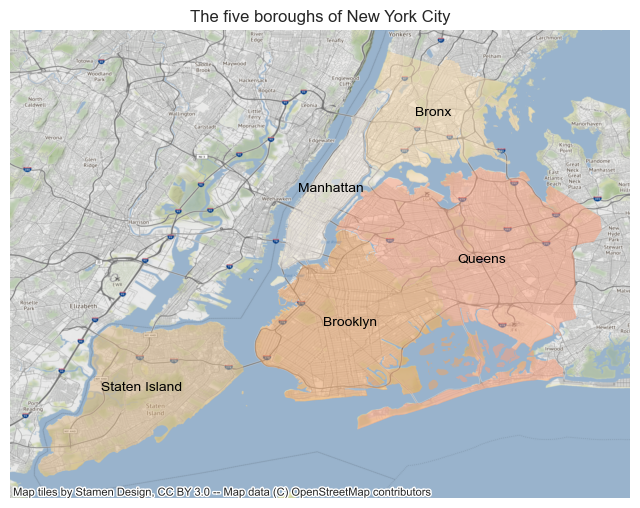

In [30]:
fig, ax= plt.subplots(figsize=(8, 8))
plt.title('The five boroughs of New York City')

# Plot the geometry of NYC
gdf['geometry'].plot(ax=ax,alpha=0.5, color=gdf['color'])

# Annotate borough names in the center of each borough geometry
gdf.reset_index().apply(lambda x: ax.annotate(x['BoroName'], 
                                              color='black', 
                                              xy=x.geometry.centroid.coords[0],
                                              ha='center'), axis=1)
# Load a map
cx.add_basemap(ax, crs=gdf.crs, zoom=12)
# Omitt x,y coordinates
plt.xticks([]),plt.yticks([]);

## New York City Neighbourhoods

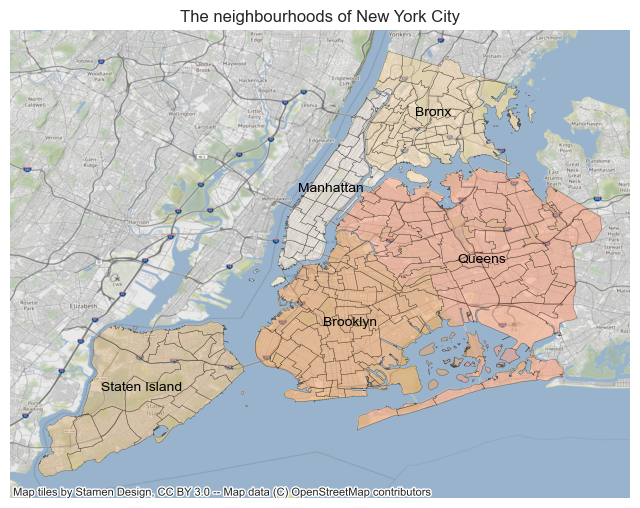

In [31]:
fig, ax= plt.subplots(figsize=(8, 8))
plt.title('The neighbourhoods of New York City')

# Plot the geometry of NYC neighbourhoods
geofile["geometry"].plot(ax=ax, alpha=0.5, edgecolor='black', color=geofile['color'])

# Annotate borough names in the center of each borough geometry
gdf.reset_index().apply(lambda x: ax.annotate(x['BoroName'], 
                                              color='black', 
                                              xy=x.geometry.centroid.coords[0],
                                              ha='center'), axis=1)
# Load a map
cx.add_basemap(ax, crs=geofile.crs, zoom=12)
# Omitt x,y coordinates
plt.xticks([]),plt.yticks([]);

### Distribution of properties per location

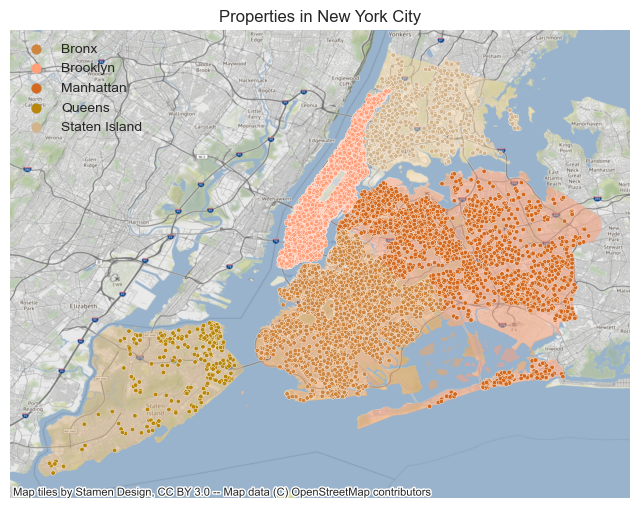

In [32]:
# Color map for markers
col_map={'Staten Island': 'darkgoldenrod' , 
         'Queens'       : 'chocolate' , 
         'Brooklyn'     : 'peru' , 
         'Manhattan'    : 'lightsalmon' , 
         'Bronx'        : 'tan'}

fig,ax=plt.subplots(figsize=(8,8))
plt.title('Properties in New York City')

# Plot the geometry of NYC boroughs
geofile["geometry"].plot(ax=ax,alpha=0.5, color=geofile['color'])

# Scatterplot of longitude, latitude coordinates
sns.scatterplot(data=data, x='longitude', y='latitude', hue='borough',
                palette=col_map, s=10, ax=ax)
# Add a map
cx.add_basemap(ax, crs=geofile.crs, zoom=12)

# Legend configuration
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles,labels=boroughs) # set legend in order

# Omitt x,y coordinates and labels
plt.xticks([]),plt.yticks([]);
plt.xlabel(''),plt.ylabel('');

### Distribution of properties per neighbourhood

In [33]:
# Calculating median per neighbourhood
gdf_count_nbhd = data[['neighbourhood','id']].groupby('neighbourhood').count().reset_index()
gdf_count_nbhd.rename(columns={'id':'count'}, inplace=True)
# Merge with geometry information and convert to geo DF
gdf_count_nbhd = gdf_count_nbhd.merge(geofile[['neighbourhood','geometry']], on='neighbourhood')
gdf_count_nbhd = gpd.GeoDataFrame(gdf_count_nbhd)

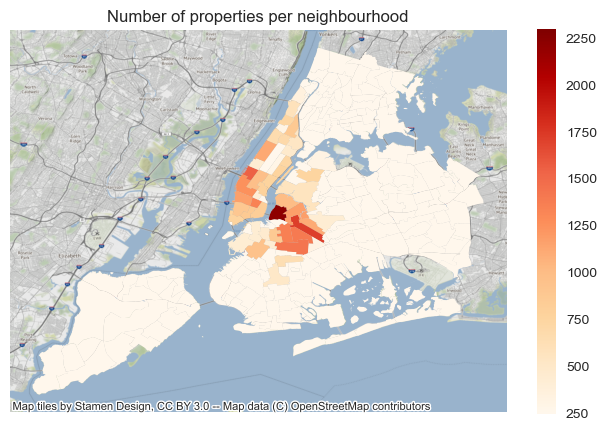

In [34]:
fig,ax=plt.subplots(figsize=(8,5))
plt.title('Number of properties per neighbourhood')

# Plot count per neighbourhood with color bar
gdf_count_nbhd.plot(column='count',
                    cmap='OrRd', 
                    legend=True,
                    vmax=2300,
                    vmin=250,
                    ax=ax)

# Add a map
cx.add_basemap(ax, crs=geofile.crs, zoom=12)

# Omitt x,y coordinates and labels
plt.xticks([]),plt.yticks([]);
plt.xlabel(''),plt.ylabel('');

## Popularity distribution
Here, we analyze the sum of reviews per month for each neighbourhood.

In [35]:
df = data.loc[data['reviews_per_month'] > 0]
df[['reviews_per_month']].describe().T

count  mean  std  min  25%  50%  75%   max
reviews_per_month 37354.00  1.38 1.69 0.01 0.19 0.71 2.03 58.50

In [36]:
# Calculating sum of reviews per month per neighbourhood
gdf_rev_nbhd = data[['neighbourhood','reviews_per_month']].groupby('neighbourhood').sum().reset_index()
gdf_rev_nbhd.rename(columns={'reviews_per_month':'reviews per month'}, inplace=True)
gdf_rev_nbhd = gdf_rev_nbhd.merge(geofile[['neighbourhood','geometry']], on='neighbourhood')
gdf_rev_nbhd = gpd.GeoDataFrame(gdf_rev_nbhd)

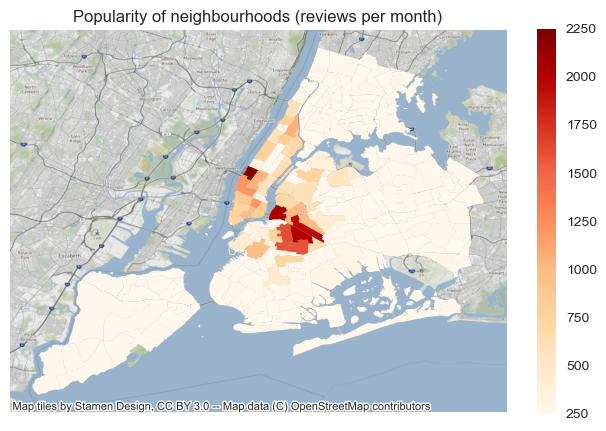

In [37]:
fig,ax=plt.subplots(figsize=(8,5))
plt.title('Popularity of neighbourhoods (reviews per month)')

# Plot of sum per neighbourhood with colorbar
gdf_rev_nbhd.plot(column='reviews per month',
                  cmap='OrRd', 
                  legend=True,
                  vmax=2250,
                  vmin=250,
                  ax=ax)

# Add a map
cx.add_basemap(ax, crs=geofile.crs, zoom=12)

# Omitt x,y coordinates and labels
plt.xticks([]),plt.yticks([]);
plt.xlabel(''),plt.ylabel('');

<b>Business implications:</b>
- The listings are mainly located in Manhattan or near Manhattan in Brooklyn and Queens.
- The most popular neighbourhoods are in Manhattan, or outside but near Manhattan in Brooklyn and Queens.
- Thus, the Company's expansion plan for outside Manhattan should involve Queens and Brooklyn neighbourhoods near Manhattan.

## Availability

In [38]:
grouping = ['borough', 'available']
df = data[['borough', 'available', 'id']].groupby(grouping).count()
df.columns = ['count']
df['%'] = data[['borough', 'available']].groupby('borough').value_counts(normalize=True)*100
display(df)

count     %
borough       available             
Bronx         0            166 16.29
              1            853 83.71
Brooklyn      0           7691 39.54
              1          11761 60.46
Manhattan     0           7797 38.23
              1          12599 61.77
Queens        0           1327 24.42
              1           4106 75.58
Staten Island 0             40 11.17
              1            318 88.83

<b>Business implications:</b>
- Bronx and Staten Island have the highest vacancy, above 80%.
- Occupation is higher in Manhattan and Brooklyn, around 38-39%.
- The most popular neighbourhoods are in Manhattanm, or outside but near Manhattan in Brooklyn and Queens.
- Thus, the Company's expansion plan should focus Manhattan, Brooklyn, and Queens.

## Price distribution

In [39]:
to_drop = ['id', 'host_id', 'latitude', 'longitude']
points = ['min', '25%', '50%', '75%', 'max']
df_description = data.drop(labels=to_drop, axis=1).describe().loc[points].T
display( df_description.head(1) )

min   25%    50%    75%    max
price 20.00 70.00 105.00 175.00 500.00

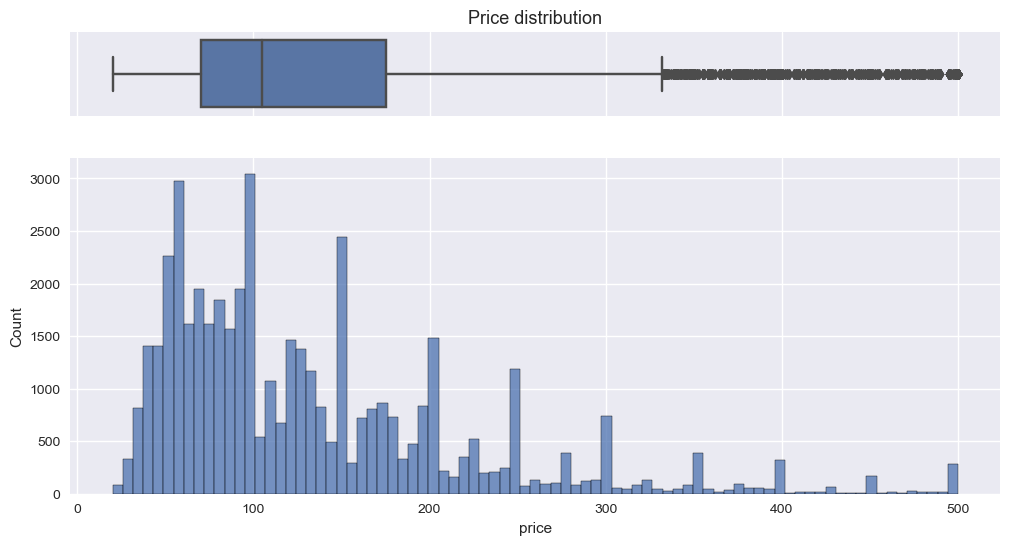

In [40]:
# Ploting price distribution: histogram and boxplot
f, (ax_box, ax_hist) = plt.subplots(2, 
                                    sharex=True, 
                                    gridspec_kw={"height_ratios": (.20, .80)},
                                    figsize=(12, 6))
 
# assigning a graph to each ax
ax_box.set_title('Price distribution', fontsize=13)
sns.boxplot(data=data, x='price', ax=ax_box)
sns.histplot(data=data, x='price', ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

### Price distribution per borough

In [41]:
# Columns to drop: 'count', 'mean', 'std' (given by the ".describe()" method)
to_drop = [('price','count'), ('price','mean'), ('price','std')]
df = data[['borough', 'price']].groupby('borough').describe()
# Drop colums
df.drop(columns=to_drop, inplace=True)
display( df )

price                           
                min   25%    50%    75%    max
borough                                       
Bronx         21.00 48.00  69.00 100.00 500.00
Brooklyn      20.00 60.00  92.00 149.00 500.00
Manhattan     20.00 95.00 149.00 205.00 500.00
Queens        20.00 53.00  75.00 111.00 500.00
Staten Island 20.00 50.00  75.00 108.25 450.00

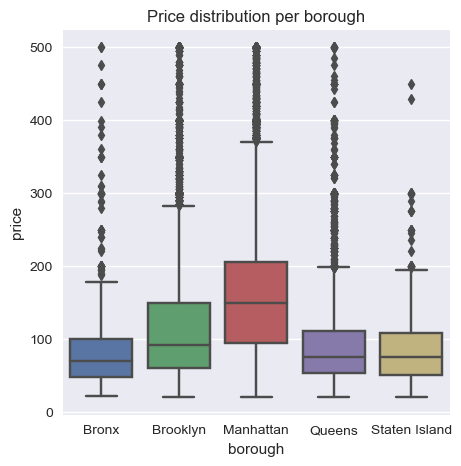

In [42]:
fig = plt.subplots(figsize=(5, 5))
plt.title('Price distribution per borough')

# Plot (sorted by borough)
sns.boxplot(data=data.sort_values('borough'), x='borough', y='price');

### Price distribution per borough and room type

In [43]:
df = data[['borough', 'room_type', 'price']].groupby(['borough', 'room_type']).describe()
# Drop columns 
df.drop(columns=to_drop, inplace=True)
display( df )

price                            
                                min    25%    50%    75%    max
borough       room_type                                        
Bronx         Entire home/apt 28.00  80.00 100.00 140.00 500.00
              Private room    21.00  40.00  54.00  70.00 500.00
Brooklyn      Entire home/apt 20.00 102.00 144.50 195.00 500.00
              Private room    20.00  50.00  64.50  80.00 500.00
Manhattan     Entire home/apt 35.00 140.00 185.00 250.00 500.00
              Private room    20.00  67.00  90.00 120.00 500.00
Queens        Entire home/apt 20.00  90.00 120.00 165.00 500.00
              Private room    20.00  47.00  59.50  75.00 500.00
Staten Island Entire home/apt 48.00  75.00 100.00 150.00 450.00
              Private room    20.00  40.00  50.00  75.00 300.00

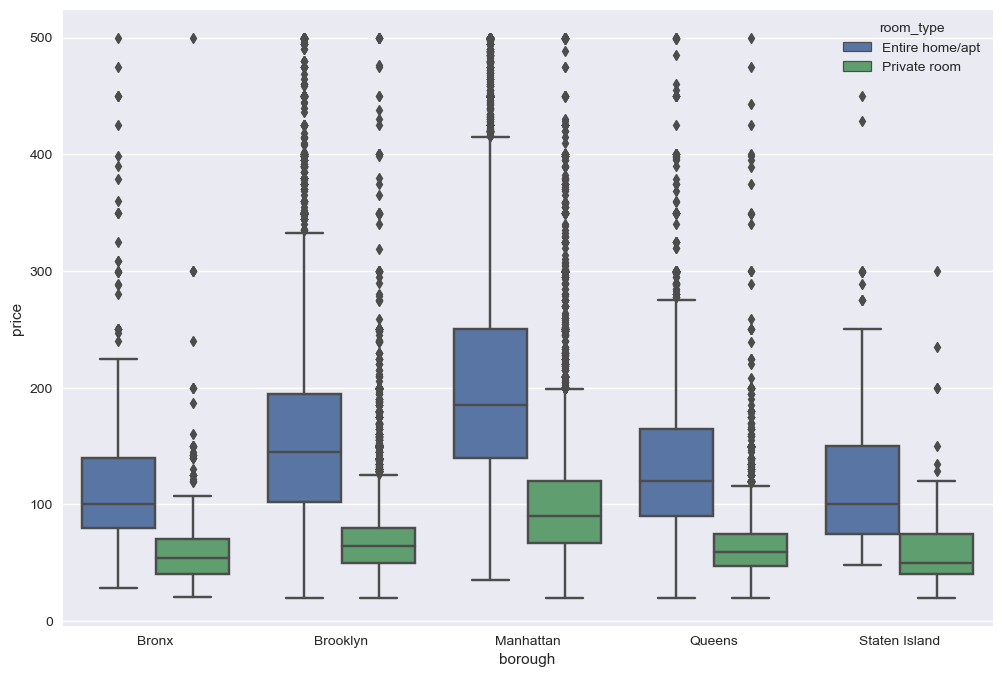

In [44]:
plt.figure(figsize=(12,8))
# Plot (sorted by borough)
sns.boxplot(data=data.sort_values('borough'), 
            x='borough', y='price', hue='room_type');

### Median price per Neighbourhoods

In [45]:
# Calculating median per neighbourhood
gdf_median_nbhd = data[['neighbourhood','price']].groupby('neighbourhood').median().reset_index()
gdf_median_nbhd.rename(columns={'price':'median price'}, inplace=True)
# Get geospatial information and convert to geo DF
gdf_median_nbhd = gdf_median_nbhd.merge(geofile[['neighbourhood','geometry']], on='neighbourhood')
gdf_median_nbhd = gpd.GeoDataFrame(gdf_median_nbhd)

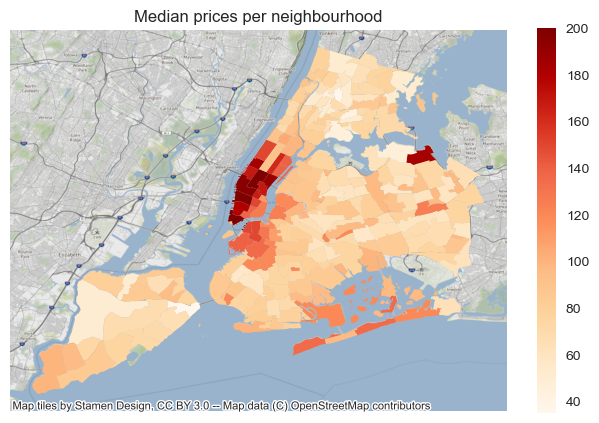

In [46]:
fig,ax=plt.subplots(figsize=(8,5))
plt.title('Median prices per neighbourhood')

# Plot median price per neighbourhood with colorbar
gdf_median_nbhd.plot(column='median price',
                     cmap='OrRd', 
                     legend=True, 
                     ax=ax)

# Add a map
cx.add_basemap(ax, crs=geofile.crs, zoom=12)

# Omitt x,y coordinates and labels
plt.xticks([]),plt.yticks([]);
plt.xlabel(''),plt.ylabel('');

<b>Business implications:</b>
- The most expensive neighbourhoods are in Lower Manhattan, Mid Manhattan, Central Park Manhattan, and Brooklyn near near Manhattan.
- Some neighbourhoods in Queens far from Manhattan also have average-to-high median prices. 

## Profitability

Here, we estimate the profitability of <b>available</b> properties with <b>at least 1 review</b> following the formula:

$$ profitability = \frac{price * (minimum\_nights + 1) * number\_of\_reviews}{\sqrt{availability\_365}} $$

In [47]:
# Select properties available and with 1 or more reviews
df_prof = data.loc[(data['available'] == 1) & (data['number_of_reviews'] >= 1)].copy()
# Compute numerator and denominator
num = df_prof['price'] * (df_prof['minimum_nights'] + 1) * df_prof['number_of_reviews']
den = df_prof['availability_365']**(1/2)
# Create the column 'profitability'
df_prof['profitability'] =  num/den
# Sort according to profitability in descending order
df_prof = df_prof.sort_values('profitability', ascending=False)

# Columns to select
cols = ['id', 'borough' , 'neighbourhood', 'price', 'minimum_nights',
        'number_of_reviews', 'availability_365', 'profitability' ]
# Display DF                   
display(df_prof.loc[:, cols])

id    borough                                   neighbourhood  \
3605    2154075   Brooklyn                                         Bedford   
6375    4644632   Brooklyn                                         Bedford   
9422    7225366  Manhattan                           Midtown-Midtown South   
7178    5240711  Manhattan                         Turtle Bay-East Midtown   
15899  12855469  Manhattan                   Upper East Side-Carnegie Hill   
...         ...        ...                                             ...   
38361  30208369   Brooklyn                                Bensonhurst East   
44869  34442975   Brooklyn                         Cypress Hills-City Line   
36351  28917395   Brooklyn  Sheepshead Bay-Gerritsen Beach-Manhattan Beach   
36233  28816767   Brooklyn  Sheepshead Bay-Gerritsen Beach-Manhattan Beach   
33243  26252841     Queens                                    Forest Hills   

       price  minimum_nights  number_of_reviews  availability_365  \
3605  112.00             200                314                42   
6375  130.00             200                271                64   
9422  450.00               4                206                 1   
7178  289.00              10                169                 3   
15899 100.00             365                 27                17   
...      ...             ...                ...               ...   
38361  40.00               1                  1               335   
44869  40.00               1                  1               340   
36351  39.00               1                  1               360   
36233  37.00               1                  1               364   
33243  30.00               1                  1               363   

       profitability  
3605      1090734.58  
6375       885153.75  
9422       463500.00  
7178       310182.01  
15899      239673.70  
...              ...  
38361           4.37  
44869           4.34  
36351           4.11  
36233           3.88  
33243           3.15  

[24923 rows x 8 columns]

In [48]:
df_prof[['profitability']].describe().T

count    mean      std  min    25%    50%     75%        max
profitability 24923.00 2802.26 12595.93 3.15 242.23 820.16 2513.61 1090734.58

#### Excluding the top 5% (extreme values) for better visualization

In [49]:
q_95 = df_prof['profitability'].quantile(0.95)
df = df_prof.loc[df_prof['profitability'] <= q_95]

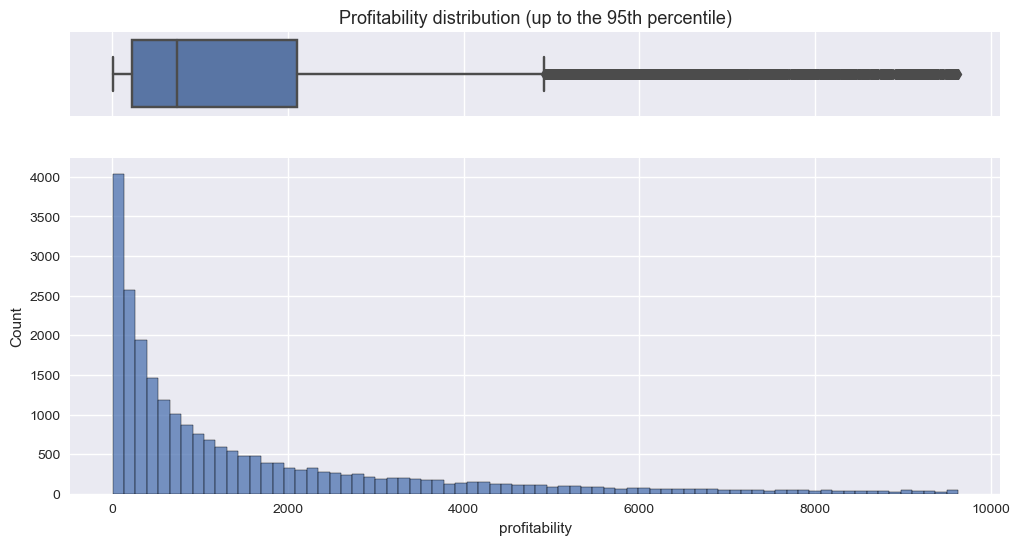

In [50]:
# Ploting profitability distribution: histogram and boxplot
f, (ax_box, ax_hist) = plt.subplots(2, 
                                    sharex=True, 
                                    gridspec_kw={"height_ratios": (.20, .80)},
                                    figsize=(12, 6))
 
# assigning a graph to each ax
ax_box.set_title('Profitability distribution (up to the 95th percentile)', fontsize=13)
sns.boxplot(data=df, x='profitability', ax=ax_box)
sns.histplot(data=df, x='profitability', ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

In [51]:
# Calculating median profitability per neighbourhood
gdf_md_prof_nbhd = df_prof[['neighbourhood','profitability']].groupby('neighbourhood').median().reset_index()
gdf_md_prof_nbhd.rename(columns={'profitability':'median profitability'}, inplace=True)
# Get geospatial information and convert to geo DF
gdf_md_prof_nbhd = gdf_md_prof_nbhd.merge(geofile[['neighbourhood','geometry']], on='neighbourhood')
gdf_md_prof_nbhd = gpd.GeoDataFrame(gdf_md_prof_nbhd)

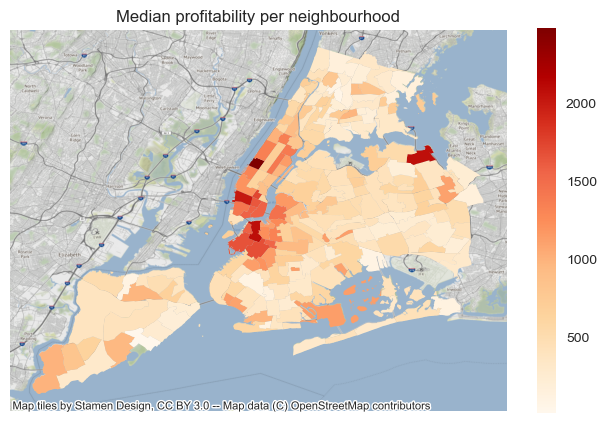

In [52]:
fig,ax=plt.subplots(figsize=(8,5))
plt.title('Median profitability per neighbourhood')

# Plot median profitability per neighbourhood with colorbar
gdf_md_prof_nbhd.plot(column='median profitability',
                      cmap='OrRd', 
                      legend=True, 
                      ax=ax)

# Add a map
cx.add_basemap(ax, crs=geofile.crs, zoom=12)

# Omitt x,y coordinates and labels
plt.xticks([]),plt.yticks([]);
plt.xlabel(''),plt.ylabel('');

<b>Business implications:</b>
- Future expansions in Brooklyn and Queens should focus on the neighbourhoods with higher profitability, as indicated in the map.

# Insights

Here, we verify some hypotheses regarding prices in different regions of Manhattan based on the Company's current pricing policy. 

### Hypothesis 1: Rent prices in the neighbourhoods around the Central Park are 50% more expensive than in Upper Manhattan.

<b>False.</b> The rent prices are 68.5% more expensive in neighbourhoods around the Central Park than in upper Manhattan.<br> 
<b>Business implications:</b> Rent prices are higher than expected for the neighbourhoods around the Central Park, so the company should adjust the prices accordingly. 

In [53]:
# Select Manhattan and subareas of interest
df = data.loc[data['borough'] == 'Manhattan']
df = df.loc[(df['Manhattan']=='C. Park Manhattan') |
            (df['Manhattan']=='Upper Manhattan')]

# Compute median prices and rename column
df = df[['Manhattan','price']].groupby('Manhattan').median().sort_values('price')
df.rename(columns={'price':'median price'}, inplace=True)

# Compute the % change in median price
df['percent increase'] = df['median price'].pct_change() * 100
display(df)

median price  percent increase
Manhattan                                        
Upper Manhattan           89.00               NaN
C. Park Manhattan        150.00             68.54

### Hypothesis 2: Rent prices in Mid Manhattan are 20% more expensive than  in neighbourhoods around the Central Park.

<b>True.</b> <br> 
<b>Business implications:</b> The company should maintain the pricing policy for Mid Manhattan. 

In [54]:
# Select Manhattan and subareas of interest
df = data.loc[data['borough'] == 'Manhattan']
df = df.loc[(df['Manhattan']=='C. Park Manhattan') |
            (df['Manhattan']=='Mid Manhattan')]

# Compute median prices and rename column
df = df[['Manhattan','price']].groupby('Manhattan').median().sort_values('price')
df.rename(columns={'price':'median price'}, inplace=True)

# Compute the % change in median price
df['percent increase'] = df['median price'].pct_change() * 100
display(df)

median price  percent increase
Manhattan                                        
C. Park Manhattan        150.00               NaN
Mid Manhattan            180.00             20.00

### Hypothesis 3: Rent prices in Lower Manhattan are 5% cheaper than in Mid Manhattan.

<b>False.</b> The rent prices in Lower Manhattan are 8.3% cheaper than in Mid Manhattan.<br>
<b>Business implications:</b> The company pricing policy is slightly over the market price, so the company should adjust the prices accordingly.  

In [55]:
# Select Manhattan and subareas of interest
df = data.loc[data['borough'] == 'Manhattan']
df = df.loc[(df['Manhattan']=='Mid Manhattan') |
            (df['Manhattan']=='Lower Manhattan')]

# Compute median prices and rename column
df = df[['Manhattan','price']].groupby('Manhattan').median().sort_values('price', ascending=False)
df.rename(columns={'price':'median price'}, inplace=True)

# Compute the % change in median price
df['percent increase'] = df['median price'].pct_change() * 100
display(df)

median price  percent increase
Manhattan                                      
Mid Manhattan          180.00               NaN
Lower Manhattan        165.00             -8.33

### Hypothesis 4: Rent prices in Mid Manhattan are 100% more expensive than in Upper Manhattan.

<b>True.</b> The rent prices in Mid Manhattan are around the expected, that is,102.2% more expensive than in Upper Manhattan.<br> 
<b>Business implications:</b> The company should maintain the pricing policy for Mid and Upper Manhattan. 

In [56]:
# Select Manhattan and subareas of interest
df = data.loc[data['borough'] == 'Manhattan']
df = df.loc[(df['Manhattan']=='Mid Manhattan') |
            (df['Manhattan']=='Upper Manhattan')]

# Compute median prices and rename column
df = df[['Manhattan','price']].groupby('Manhattan').median().sort_values('price')
df.rename(columns={'price':'median price'}, inplace=True)

# Compute the % change in median price
df['percent increase'] = df['median price'].pct_change() * 100
display(df)

median price  percent increase
Manhattan                                      
Upper Manhattan         89.00               NaN
Mid Manhattan          180.00            102.25

### Hypothesis 5: Rent prices of the most reviewed properties are 10% cheaper than the least reviewed properties.

<b>False.</b> The median rent prices are the same when comparig the most and least reviewed.<br> 
<b>Business implications:</b> In general, the prices are not related to the number of reviews.

In [57]:
# Select properties that have been reviewed
df_reviewed = data.loc[data['number_of_reviews'] > 0].copy()

# Get 1st and 3rd quartiles
rev_25 = df_reviewed['number_of_reviews'].quantile(0.25)
rev_75 = df_reviewed['number_of_reviews'].quantile(0.75)

# Apply the categorization
reviews = df_reviewed['number_of_reviews'].apply(lambda x: 'most reviewed' if x > rev_75 else
                                                           'least reviewed' if x < rev_25 else
                                                           'intermediate')
# Create column
df_reviewed['reviewed_range'] = reviews

In [58]:
# Select columns and categories of interest
df = df_reviewed[['reviewed_range', 'price']]
df = df.loc[df['reviewed_range'] != 'intermediate']

# Compute median and rename column
df = df.groupby('reviewed_range').median()
df.rename(columns={'price':'median price'}, inplace=True)

# Compute the % change in median price
df['percent change'] = df['median price'].pct_change() * 100
display(df)

median price  percent change
reviewed_range                              
least reviewed        100.00             NaN
most reviewed         100.00            0.00

### Hypothesis 6: In Manhattan, rent prices of the most reviewed properties are 10% cheaper than the least reviewed properties.

<b>True.</b> In Manhattan, the rent prices were around the expected, that is, the most reviewed (4th quartile) propeties are 11% cheaper than than the least reviewed (1st quartile). <br> 
<b>Business implications:</b> In Manhattan, which is the most expensive borough, the prices are related to the number of reviews, indicating that properties with lower rents are likely to receive more guests. The company may offer price discount for properties with few reviews to reduce the vacancy.

In [59]:
# Select columns and categories of interest
df = df_reviewed[['borough', 'reviewed_range', 'price']]
df = df.loc[(df['borough'] == 'Manhattan') & (df['reviewed_range'] != 'intermediate')]

# Compute median and rename column
df = df.groupby(['borough', 'reviewed_range']).median()
df.rename(columns={'price':'median price'}, inplace=True)

# Compute the % change in median price
df['percent change'] = df['median price'].pct_change() * 100
display(df)

median price  percent change
borough   reviewed_range                              
Manhattan least reviewed        145.00             NaN
          most reviewed         129.00          -11.03

### Hypothesis 7: Rent prices of the most popular properties are 10% cheaper than the least popular properties.

<b>False.</b> Properties in the 4th quartile of "reviews per month" are 3.8% cheaper than properties in the 1st quartile. <br> 
<b>Business implications:</b> In general, rent prices are less related to popularity than expected.

In [60]:
# Considering the DF df_reviewed, 
# get 1st and 3rd quartiles
pop_25 = df_reviewed['reviews_per_month'].quantile(0.25)
pop_75 = df_reviewed['reviews_per_month'].quantile(0.75)
# Apply categorization
rev_pop = df_reviewed['reviews_per_month'].apply(lambda x:'most popular' if x > pop_75 else
                                                          'least popular' if x < pop_25 else
                                                          'intermediate')
df_reviewed['popularity'] = rev_pop

In [61]:
# Select columns and categories of interest
df = df_reviewed[['popularity', 'price']]
df = df.loc[df['popularity'] != 'intermediate']

# Compute median prices and rename column
df = df.groupby('popularity').median()
df.rename(columns={'price':'median price'}, inplace=True)

# Compute the % change in median price
df['percent change'] = df['median price'].pct_change() * 100
display(df)

median price  percent change
popularity                                 
least popular        104.00             NaN
most popular         100.00           -3.85

### Hypothesis 8: In Manhattan, the most popular properties are 10% cheaper than the least popular properties.

<b>False.</b> In fact, the most popular properties are 5.3% more expensive than the least popular.<br> 
<b>Business implications:</b> In Manhattan, the company may increase the prices of popular properties up to 5% considering the localization.

In [62]:
# Select columns and categories of interest
df = df_reviewed[['borough', 'popularity', 'price']]
df = df.loc[(df['borough'] == 'Manhattan') & (df['popularity'] != 'intermediate')]

# Compute median prices and rename column
df = df.groupby(['borough', 'popularity']).median()
df.rename(columns={'price':'median price'}, inplace=True)

# Compute the % change in median price
df['percent change'] = df['median price'].pct_change() * 100
df

median price  percent change
borough   popularity                                 
Manhattan least popular        133.00             NaN
          most popular         140.00            5.26

### Hypothesis 9: The most popular properties are 100% more profitable than the least popular properties.

<b>False.</b> The median profitability of the most popular properties is 386.4% higher than that of the least popular properties.<br> 
<b>Business implications:</b> The company should focus on buying properties with a good track record of reviews per month. Regarding the properties already in the portolio, the company may consider implement strategies for increase popularity (e.g., price discounts, marketing etc.). 

In [63]:
# Select columns and categories of interest
df = df_reviewed[['id', 'popularity']]
df = df.merge(df_prof[['id', 'profitability']], on='id')
df.drop('id', axis=1, inplace=True)
df = df.loc[df['popularity'] != 'intermediate']

# Compute median profitability and rename column
df = df.groupby('popularity').median()
df.rename(columns={'profitability':'median profitability'}, inplace=True)

# Compute the % change in median price
df['percent increase'] = df['median profitability'].pct_change() * 100
display(df)

median profitability  percent increase
popularity                                           
least popular                300.37               NaN
most popular                1460.97            386.40

### Hypothesis 10: The most popular properties are 100% more profitable than intermediate popular properties.

<b>False.</b> The median profitability of the most popular properties is 115.3% higher than that of intermediate popularity.<br> 
<b>Business implications:</b> The company may buy properties with intermediate popularity and implement strategies for increasing their popularity. Regarding the company portfolio, the company may implement strategies and target a 115% profitability increase of the intermediate popular properties.

In [64]:
# Select columns and categories of interest
df = df_reviewed[['id', 'popularity']]
df = df.merge(df_prof[['id', 'profitability']], on='id')
df.drop('id', axis=1, inplace=True)
df = df.loc[df['popularity'] != 'least popular']

# Compute median profitability and rename column
df = df.groupby('popularity').median()
df.rename(columns={'profitability':'median profitability'}, inplace=True)
# Compute the % change in median price
df['percent_change'] = df['median profitability'].pct_change() * 100
display(df)

median profitability  percent_change
popularity                                        
intermediate                678.64             NaN
most popular               1460.97          115.28

# Questions from the business team

### Analyze prices outside but near Manhattan

<b>Bronx:</b> prices are 15.4% higher near Manhattan.

In [65]:
# Select Bronx, compute median prices and rename column
df_bronx_nm = data.loc[data['borough'] == 'Bronx']
df_bronx_nm = df_bronx_nm[['Near Manhattan','price']].groupby('Near Manhattan').median()
df_bronx_nm.rename(columns={'price':'median price'}, inplace=True)

# Compute the % change in median price
df_bronx_nm['percent increase'] = df_bronx_nm['median price'].pct_change() * 100
display(df_bronx_nm)

median price  percent increase
Near Manhattan                                
0                      65.00               NaN
1                      75.00             15.38

<b>Brooklyn:</b> prices are 37.5% higher near Manhattan.

In [66]:
# Select Brooklyn, compute median prices and rename column
df_brooklyn_nm = data.loc[data['borough'] == 'Brooklyn']
df_brooklyn_nm = df_brooklyn_nm[['Near Manhattan','price']].groupby('Near Manhattan').median()
df_brooklyn_nm.rename(columns={'price':'median price'}, inplace=True)

# Compute the % change in median price
df_brooklyn_nm['percent increase'] = df_brooklyn_nm['median price'].pct_change() * 100
display(df_brooklyn_nm)

median price  percent increase
Near Manhattan                                
0                      80.00               NaN
1                     110.00             37.50

<b>Queens:</b> prices are 23.2% higher near Manhattan.

In [67]:
# Select Queens, compute median prices and rename column
df_queens_nm = data.loc[data['borough'] == 'Queens']
df_queens_nm = df_queens_nm[['Near Manhattan','price']].groupby('Near Manhattan').median()
df_queens_nm.rename(columns={'price':'median price'}, inplace=True)

# Compute the % change in median price
df_queens_nm['percent increase'] = df_queens_nm['median price'].pct_change() * 100
display(df_queens_nm)

median price  percent increase
Near Manhattan                                
0                      69.00               NaN
1                      85.00             23.19

**Business implications**
- In fact, median prices in neighbourhoods near Manhattan (East River) are more expensive than in other neighbourhoods.
- The Company expansion plan for outside but near Manhattan is supported by the data. 

### Prices around the Central Park

Here, we analyse median prices of properties in 7 distance ranges from the Central Park. From the Central Park boundaries, distance ranges increased by 150 meters (about 492 feet).

In [68]:
# Central Park coordinates
cpark = [[-73.9495,40.7969],
         [-73.95807266235352,40.80068603561921],
         [-73.98201942443848,40.76825672305777],
         [-73.97317886352539,40.76455136505513],
         [-73.9495,40.7969]]

# Create polygon
cpark = Polygon(cpark)

# Create a geo DF for the Central Park geometry
gdf_cp = gpd.GeoDataFrame(index=['central_park'])
gdf_cp['geometry'] = cpark

# Setting Coordinate Reference System to epsg:3857 (meters)
gdf_cp = gdf_cp.set_crs(epsg=3857)

In [69]:
# Create a geo DF for Manhattan neighbourhoods, with epsg:3857
gdf_man = geofile.loc[geofile['BoroName']=='Manhattan'].copy()
gdf_man = gdf_man.set_crs(epsg=3857, allow_override=True)

In [70]:
# Also set data CRS to 3857
data = data.set_crs(epsg=3857, allow_override=True)

In [71]:
# Get the properties within the given distance range
for i in range(1, 8):
    # Define the distance range(e.g. distance_1 = 150m, distance_1 = 300m )
    globals()[f'distance_{i}'] = ((i * 150)/40075000) * 360 # distance is geospatial
    
    # Get the CP geoDF and buffer the given distance
    globals()[f'gdf_cp_{i}'] = gdf_cp.buffer(globals()[f'distance_{i}'])
    
    # Create a geoDF based on the extended distance from the CP
    globals()[f'gdf_cp_{i}'] = gpd.GeoDataFrame({'geometry': globals()[f'gdf_cp_{i}']})
    
    # Join the properties from data that are inside the given area
    globals()[f'gdf_cp_{i}'] = gpd.sjoin(data, globals()[f'gdf_cp_{i}'], how='inner')
    
    # Log the indeces of properties from the CP to the i-th distance range 
    globals()[f'idx_{i}'] = globals()[f'gdf_cp_{i}'].index
    
    # Set column with the CP distance range "i"
    globals()[f'gdf_cp_{i}']['Central Park distance'] = i
    
    # For distance ranges 2 to 5
    if i > 1:
        # Here, we drop properties based on the previous step indices,
        # so we get only the properties above the previous distance range
        globals()[f'gdf_cp_{i}'] = globals()[f'gdf_cp_{i}'].drop(globals()[f'idx_{i-1}'])

# Concatenating the DFs
gdf_cp_all = pd.concat([gdf_cp_1,gdf_cp_2,gdf_cp_3,
                        gdf_cp_4,gdf_cp_5,gdf_cp_6,
                        gdf_cp_7])

In [72]:
print('7 GDF were created for properties around the Central Park')
print('Distance 1 (gdf_cp_1)', gdf_cp_1.shape)
print('Distance 2 (gdf_cp_2)', gdf_cp_2.shape)
print('Distance 3 (gdf_cp_3)', gdf_cp_3.shape)
print('Distance 4 (gdf_cp_4)', gdf_cp_4.shape)
print('Distance 5 (gdf_cp_5)', gdf_cp_5.shape)
print('Distance 6 (gdf_cp_6)', gdf_cp_6.shape)
print('Distance 7 (gdf_cp_7)', gdf_cp_7.shape)

7 GDF were created for properties around the Central Park
Distance 1 (gdf_cp_1) (392, 23)
Distance 2 (gdf_cp_2) (583, 23)
Distance 3 (gdf_cp_3) (560, 23)
Distance 4 (gdf_cp_4) (598, 23)
Distance 5 (gdf_cp_5) (812, 23)
Distance 6 (gdf_cp_6) (944, 23)
Distance 7 (gdf_cp_7) (929, 23)


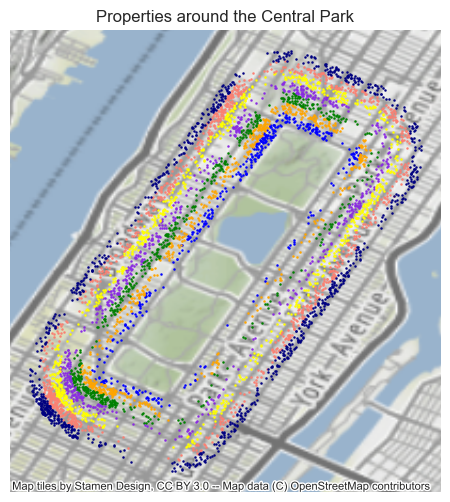

In [73]:
fig, ax= plt.subplots(figsize=(6, 6))
plt.title('Properties around the Central Park')

# Plot properties of each geo DF in specific colors
gdf_cp_1.plot(markersize=2,ax=ax, color='blue')
gdf_cp_2.plot(markersize=2,ax=ax, color='orange')
gdf_cp_3.plot(markersize=2,ax=ax, color='green')
gdf_cp_4.plot(markersize=2,ax=ax, color='blueviolet')
gdf_cp_5.plot(markersize=2,ax=ax, color='yellow')
gdf_cp_6.plot(markersize=2,ax=ax, color='salmon')
gdf_cp_7.plot(markersize=2,ax=ax, color='navy')

# Add a map
cx.add_basemap(ax, crs=geofile.crs, zoom=12)
# Omitt x,y coordinates
plt.xticks([]),plt.yticks([]);

#### Prices around the Central Park

As we can observe below, prices are little affected by the distance to the Central Park.

In [74]:
grouping = 'Central Park distance'
df = gdf_cp_all[[grouping,'price']].groupby(grouping).describe()
display(df)

price                                                
                       count   mean    std   min    25%    50%    75%    max
Central Park distance                                                       
1                     392.00 175.01 109.49 30.00  90.00 147.50 225.00 500.00
2                     583.00 176.12  99.23 39.00 100.00 150.00 225.00 500.00
3                     560.00 182.33  97.11 42.00 100.00 166.00 239.00 500.00
4                     598.00 156.04  83.34 30.00  99.00 140.00 195.00 500.00
5                     812.00 157.94  87.89 35.00  95.00 135.00 200.00 500.00
6                     944.00 159.63  91.29 30.00  96.00 135.00 200.00 500.00
7                     929.00 164.63  90.19 38.00  99.00 140.00 200.00 500.00

### The 5 most expensive neighbourhoods for each borough

In [75]:
df_most_expensives = pd.DataFrame()

for region in boroughs:
    grouping = ['borough', 'nbhd_airbnb']
    df_aux = data.loc[data['borough'] == region]
    df_aux = df_aux[['borough', 'nbhd_airbnb', 'price']].groupby(grouping).median()
    df_aux.index.rename({'nbhd_airbnb':'neighbourhood'}, inplace=True)
    df_aux.rename(columns={'price':'median price'}, inplace=True)
    df_aux = df_aux.sort_values('median price', ascending = False)
    
    df_most_expensives = pd.concat([df_most_expensives, df_aux.head()])    

In [76]:
print('The top 5 most expensive neighbouhoods per borough')
display( df_most_expensives )

The top 5 most expensive neighbouhoods per borough


median price
borough       neighbourhood                   
Bronx         West Farms                122.00
              Port Morris               109.50
              North Riverdale           105.00
              Van Nest                  103.50
              Olinville                 102.50
Brooklyn      DUMBO                     189.00
              Vinegar Hill              172.50
              Mill Basin                167.50
              Navy Yard                 150.00
              Boerum Hill               150.00
Manhattan     Tribeca                   269.00
              NoHo                      245.00
              Flatiron District         218.00
              West Village              200.00
              Financial District        200.00
Queens        Neponsit                  274.00
              Breezy Point              195.00
              Bay Terrace               184.00
              Belle Harbor              155.00
              Jamaica Estates           130.00
Staten Island Willowbrook               249.00
              Lighthouse Hill           157.50
              Grymes Hill               125.00
              Prince's Bay              118.00
              Castleton Corners         107.50

### Profitability per neighbourhood

In [77]:
df_most_profitable = pd.DataFrame()

for region in boroughs:
    grouping = ['borough', 'nbhd_airbnb']
    df_aux = df_prof.loc[df_prof['borough'] == region]
    df_aux = df_aux[['borough', 'nbhd_airbnb', 'profitability']].groupby(grouping).median()
    df_aux.index.rename({'nbhd_airbnb':'neighbourhood'}, inplace=True)
    df_aux.rename(columns={'profitability':'median profitability'}, inplace=True)
    df_aux = df_aux.sort_values('median profitability', ascending = False)
    
    df_most_profitable = pd.concat([df_most_profitable, df_aux.head()])    

In [78]:
print('The top 5 most profitable neighbouhoods per borough')
display( df_most_profitable )

The top 5 most profitable neighbouhoods per borough


median profitability
borough       neighbourhood                          
Bronx         Castle Hill                     1460.66
              Mount Eden                      1122.58
              Van Nest                        1055.88
              Spuyten Duyvil                   987.10
              North Riverdale                  935.82
Brooklyn      DUMBO                           5209.75
              Cobble Hill                     2216.50
              Park Slope                      2128.24
              Downtown Brooklyn               1948.56
              Navy Yard                       1873.56
Manhattan     Nolita                          2245.98
              West Village                    2018.03
              Greenwich Village               2015.76
              Gramercy                        1856.22
              East Village                    1714.06
Queens        Bay Terrace                     2068.05
              College Point                    735.98
              Long Island City                 704.79
              Fresh Meadows                    643.09
              Neponsit                         633.17
Staten Island Castleton Corners               2367.90
              Silver Lake                     1960.00
              Eltingville                     1527.29
              Richmondtown                    1423.05
              Shore Acres                     1373.95

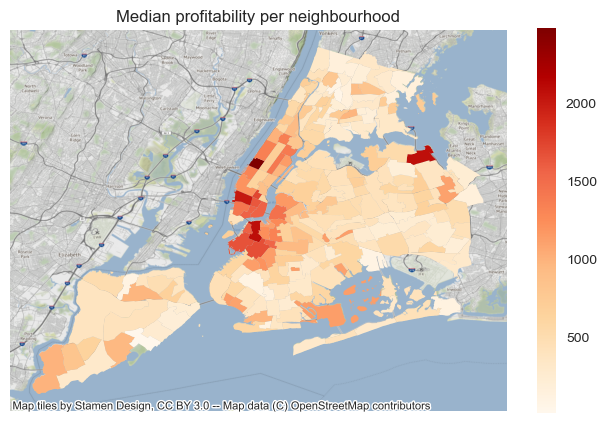

In [79]:
fig,ax=plt.subplots(figsize=(8,5))
plt.title('Median profitability per neighbourhood')

# Plot median profitability per neighbourhood with colorbar
gdf_md_prof_nbhd.plot(column='median profitability',
                      cmap='OrRd', 
                      legend=True, 
                      ax=ax)

# Add a map
cx.add_basemap(ax, crs=geofile.crs, zoom=12)

# Omitt x,y coordinates and labels
plt.xticks([]),plt.yticks([]);
plt.xlabel(''),plt.ylabel('');

# Selecting properties

The business team requested the development of an algorithm to identify the best properties for buying in the target regions: Manhattan and near neighbourhoods outside Manhattan. 

- Based on the complete dataset `data`, the <b>available properties with at least 1 review</b> were selected and the potential profitability was estimated using the proposed formula. This is the dataframe `df_prof`
- Based on `df_prof`, those <b>properties in the target borough and neighbourhoods</b> were selected. This is the dataframe `df_sample`
- Based on `df_sample`, the 3rd quartile was computed for the `profitability` and `availability_365`, and the median for the `reviews_per_month`. Then, <b>the most profitable and available properties were selected </b> (those in the 4th quartile), with `reviews_per_month` <b>above the median.</b> 
- This resulted in the dataset `df_selection` with the properties the business team should further evaluate for buying decisions.

#### Function for calculating profitability

In [80]:
def compute_profitability(dataset):
    df = dataset.loc[(dataset['available'] == 1) & (dataset['number_of_reviews'] >= 1)].copy()
    
    num = df['price'] * (df['minimum_nights'] + 1) * df['number_of_reviews']
    den = df['availability_365']**(1/2)
    df['profitability'] =  num/den
    df = df.sort_values('profitability', ascending=False)
    return df

In [81]:
df_prof = compute_profitability(data)
df_prof.shape

(24923, 22)

#### Function for selecting the target regions

In [82]:
# Function for verifying whether a neighbourhood is near Manhattan
def near_manhattan(x):
    if x in bronx_nm or x in brooklyn_nm or x in queens_nm:
        return True
    else:
        return False
    
# Function for filtering properties in the target regions
def filter_target_areas(dataset):
    df = dataset.copy()
    df['filter'] = df['neighbourhood'].apply(lambda x: 1 if (near_manhattan(x) or
                                                             x in Manhattan_borough) else 
                                                       0)
    return df.loc[df['filter']==1]

In [83]:
df_sample = filter_target_areas(df_prof)
df_sample.shape

(15374, 23)

In [84]:
# Function for selecting properties based on the criteria:
# reviews_per_month above the median
# profitability and availability in the 4th quartile

def select_properties(dataset):
    df = dataset.copy()
    
    revm_q50 = df['reviews_per_month'].quantile(0.50)
    rent_q75 = df['profitability'].quantile(0.75)
    avai_q75 = df['availability_365'].quantile(0.75)
    
    df = df.loc[(df['reviews_per_month'] >= revm_q50) &
                (df['profitability'] >= rent_q75) &
                (df['availability_365'] >= avai_q75)]
    return df

## Applying the selection algorithm

In [85]:
df_selection = select_properties(df_sample)
df_selection.shape

(286, 23)

## Business/financial implications

For estimating the impact of adopting the proposed algorithm, I've compared:
- The median `profitability` of the selected properties with the target sample
- The median `reviews per month` of the selected properties with the target sample
- The median `number of reviews` of the selected properties with the target sample
- The median `availability` of the selected properties with the target sample

As shown in the tables below:
- The median profitability of the selected properties is 396.6% higher than the target sample
- The median reviews per month of the selected properties is 105.5% higher than the target sample
- The median number of reviews of the selected properties is 710% higher than the target sample
- The median availability of the selected properties is 108.1% higher than the target sample

In [86]:
print('Number of properties in the target regions:', df_sample.shape[0])
print('Number of properties selected:', df_selection.shape[0])

Number of properties in the target regions: 15374
Number of properties selected: 286


In [87]:
# Create DF
df = pd.DataFrame()
# Median profitability of the sample and the selected subsample
df.loc['sample', 'mdn profitability'] = df_sample['profitability'].median()
df.loc['selection', 'mdn profitability'] = df_selection['profitability'].median()

# Compute the % increase
df['increase (%)'] = df['mdn profitability'].pct_change() * 100
display(df)

mdn profitability  increase (%)
sample               1058.52           NaN
selection            5256.95        396.63

In [88]:
# Create DF
df = pd.DataFrame()
# Median reviews per month of the sample and the selected subsample
df.loc['sample', 'mdn reviews/month'] = df_sample['reviews_per_month'].median()
df.loc['selection', 'mdn reviews/month'] = df_selection['reviews_per_month'].median()

# Compute the % increase
df['rev. increase (%)'] = df['mdn reviews/month'].pct_change() * 100
display(df)

mdn reviews/month  rev. increase (%)
sample                  1.10                NaN
selection               2.26             105.45

In [89]:
# Create DF
df = pd.DataFrame()
# Median number of reviews of the sample and the selected subsample
df.loc['sample', 'mdn reviews'] = df_sample['number_of_reviews'].median()
df.loc['selection', 'mdn reviews'] = df_selection['number_of_reviews'].median()

# Compute the % increase
df['rev. increase (%)'] = df['mdn reviews'].pct_change() * 100
display(df)

mdn reviews  rev. increase (%)
sample           15.00                NaN
selection       121.50             710.00

In [90]:
# Create DF
df = pd.DataFrame()
# Median availability of the sample and the selected subsample
df.loc['sample', 'mdn availability'] = df_sample['availability_365'].median()
df.loc['selection', 'mdn availability'] = df_selection['availability_365'].median()

# Compute the % increase
df['rev. increase (%)'] = df['mdn availability'].pct_change() * 100
display(df)

mdn availability  rev. increase (%)
sample               149.00                NaN
selection            310.00             108.05

## Exploring the portfolio

### Location

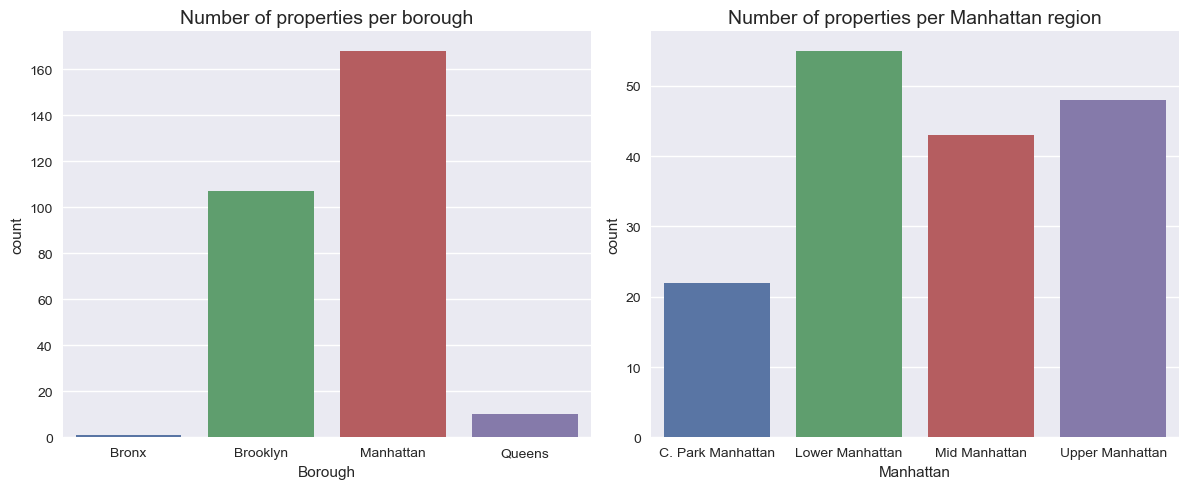

In [91]:
# Create dashboard with 6 plots
fig = plt.figure(figsize=(12, 5))
specs = gridspec.GridSpec(nrows=1, ncols=2 , figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
ax2 = fig.add_subplot(specs[0, 1])

# Plot 1
df = df_selection['borough'].value_counts().to_frame().sort_index()
df.columns=['count']
sns.barplot(data=df, y='count', x=df.index, ax=ax1)
ax1.set_title('Number of properties per borough', fontsize=14)
ax1.set(xlabel='Borough')

# Plot 2
df = df_selection['Manhattan'].value_counts().to_frame().sort_index()
df.columns=['count']
sns.barplot(data=df, y='count', x=df.index, ax=ax2)
ax2.set_title('Number of properties per Manhattan region', fontsize=14)
ax2.set(xlabel='Manhattan')

plt.tight_layout()

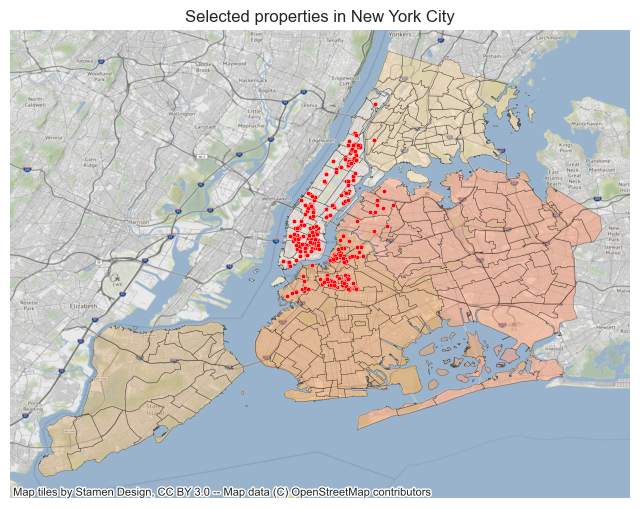

In [92]:
fig, ax= plt.subplots(figsize=(8, 8))
plt.title('Selected properties in New York City')

# Plot NYC neighbourhood geometry
geofile['geometry'].plot(ax=ax, alpha=0.5, edgecolor='black', color=geofile['color'])

# Scatterplot of the selected properties
sns.scatterplot(data=df_selection, x='longitude', y='latitude', 
                color='red', s=10, ax=ax)
# Add a map
cx.add_basemap(ax, crs=geofile.crs, zoom=12)
# Omitt x,y coordinates and labels
plt.xticks([]),plt.yticks([])
plt.xlabel(''),plt.ylabel('');

### Boroughs and neighbourhoods

In [93]:
grouping = ['borough','neighbourhood']
df = df_selection[grouping].groupby(grouping).value_counts().to_frame()
df.columns=['count']
display(df)

count
borough   neighbourhood                                          
Bronx     West Concourse                                        1
Brooklyn  Bedford                                              26
          Brooklyn Heights-Cobble Hill                          1
          Carroll Gardens-Columbia Street-Red Hook             10
          Clinton Hill                                         17
          DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill      1
          East Williamsburg                                     8
          Fort Greene                                          11
          Greenpoint                                            5
          North Side-South Side                                27
          Williamsburg                                          1
Manhattan Battery Park City-Lower Manhattan                     6
          Central Harlem North-Polo Grounds                    17
          Central Harlem South                                 12
          Chinatown                                             7
          Clinton                                              12
          East Harlem South                                     6
          East Village                                         14
          Gramercy                                              7
          Hamilton Heights                                      6
          Hudson Yards-Chelsea-Flatiron-Union Square           11
          Lenox Hill-Roosevelt Island                           7
          Lincoln Square                                        5
          Lower East Side                                       9
          Marble Hill-Inwood                                    1
          Midtown-Midtown South                                 6
          Morningside Heights                                   3
          Murray Hill-Kips Bay                                  3
          SoHo-TriBeCa-Civic Center-Little Italy                5
          Turtle Bay-East Midtown                               4
          Upper East Side-Carnegie Hill                         1
          Upper West Side                                       4
          Washington Heights South                              3
          West Village                                         14
          Yorkville                                             5
Queens    Astoria                                               5
          Hunters Point-Sunnyside-West Maspeth                  3
          Old Astoria                                           1
          Steinway                                              1

### Availability and reviews

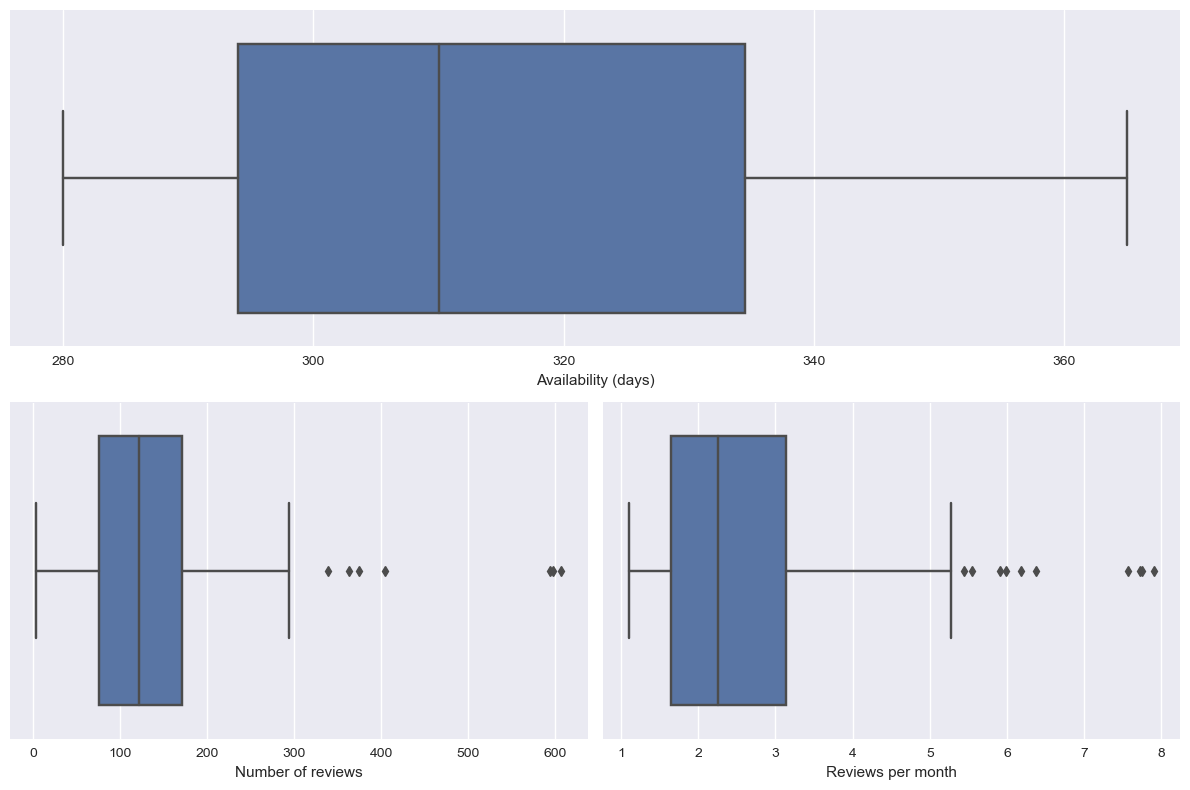

In [94]:
# Create dashboard with 3 plots
fig = plt.figure(figsize=(12, 8))
specs = gridspec.GridSpec(nrows=2, ncols=2 , figure=fig)

ax1 = fig.add_subplot(specs[0, :]) # first row, 2 coluns
ax2 = fig.add_subplot(specs[1, 0]) # second row, col 1
ax3 = fig.add_subplot(specs[1, 1]) # second row, col2

# Plot 1
sns.boxplot(data=df_selection, x='availability_365', ax=ax1)
ax1.set(xlabel='Availability (days)')

# Plot 2
sns.boxplot(data=df_selection, x='number_of_reviews', ax=ax2)
ax2.set(xlabel='Number of reviews')

## Plot 3
sns.boxplot(data=df_selection, x='reviews_per_month', ax=ax3)
ax3.set(xlabel='Reviews per month')

plt.tight_layout()

### Price and profitability

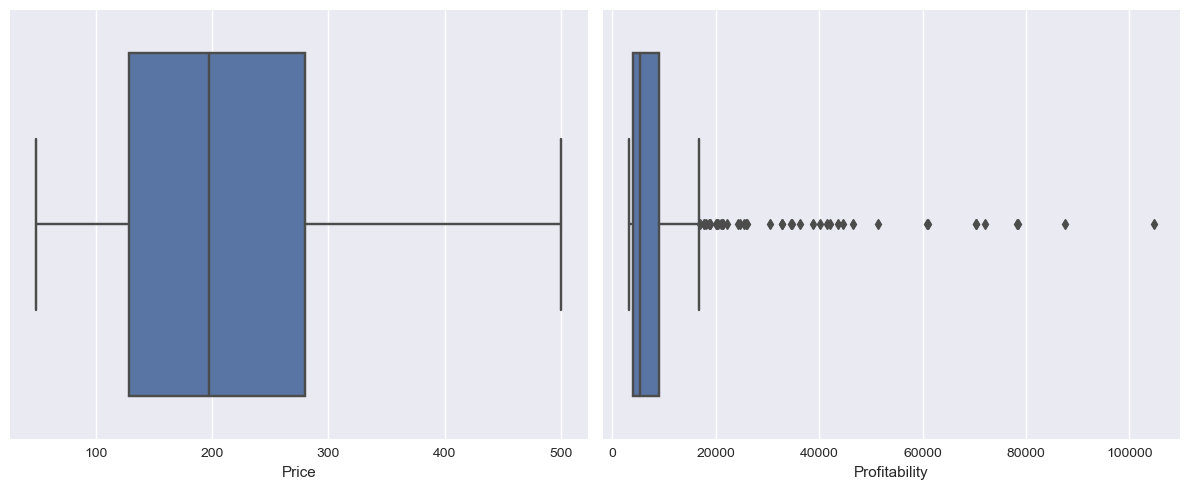

In [95]:
# Create dashboard with 4 plots
fig = plt.figure(figsize=(12, 5))
specs = gridspec.GridSpec(nrows=1, ncols=2 , figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
ax2 = fig.add_subplot(specs[0, 1])

# Plot 1
sns.boxplot(data=df_selection, x='price', ax=ax1)
ax1.set(xlabel='Price')

## Plot 2
sns.boxplot(data=df_selection, x='profitability', ax=ax2)
ax2.set(xlabel='Profitability')

plt.tight_layout()
plt.show()

### Overview of the selected properties
Here, we present the dataframe with the main features of the selected properties.

In [96]:
cols = ['id', 'host_id', 'borough', 'nbhd_airbnb',
       'room_type', 'price', 'minimum_nights',
       'reviews_per_month', 'availability_365',
       'profitability']

In [97]:
df_selected = df_selection.loc[:, cols]
display(df_selected)

id   host_id    borough         nbhd_airbnb        room_type  \
7984    6141401  10529692  Manhattan            Kips Bay  Entire home/apt   
7942    6094046  31626212  Manhattan    Theater District     Private room   
155       36703    158284  Manhattan        West Village  Entire home/apt   
9279    7091125   7719262  Manhattan   Flatiron District  Entire home/apt   
3078    1818411   9522475  Manhattan                NoHo  Entire home/apt   
...         ...       ...        ...                 ...              ...   
1218     519310   1366310     Queens            Woodside     Private room   
76        18152     69942  Manhattan     Upper East Side     Private room   
34968  27723975  24762401   Brooklyn  Bedford-Stuyvesant     Private room   
2030     903947   4734398  Manhattan              Harlem     Private room   
2015     891117   4734398  Manhattan              Harlem     Private room   

       price  minimum_nights  reviews_per_month  availability_365  \
7984  225.00              30               5.54               338   
7942  105.00              90               3.21               316   
155   225.00              45               1.24               312   
9279  299.00              28               3.39               315   
3078  455.00              30               1.36               332   
...      ...             ...                ...               ...   
1218   75.00               2               2.92               317   
76    200.00               1               1.50               322   
34968  65.00              30               2.84               365   
2030   49.00               1               7.72               342   
2015   49.00               1               7.57               339   

       profitability  
7984       104711.64  
7942        87614.25  
155         78517.75  
9279        78168.88  
3078        71992.46  
...              ...  
1218         3171.95  
76           3165.34  
34968        3164.10  
2030         3163.64  
2015         3161.64  

[286 rows x 10 columns]

## Concluding remarks

This project aimed at deriving insights from data analysis to solve the business problem of selecting the best properties available for renting in the Airbnb portfolio. The exploratory data analysis and the verification of hypotheses helped to understand patterns of price, profitability, and popularity (reviews) in NYC boroughs and neighbourhoods.

- The solution produced a diversified portfolio of properties with buy recommendation.
- The solution identified the properties with reviews per month above the median, availability in the 4th quartile and profitability in the 4th quartile.
- The most profitable properties are mainly located in Manhattan and Brooklyn near Manhattan, and few were located in Queens and only one in Bronx.
- Based on the selected properties, the business team may contact hosts and negociate acquisitions. 